# Design and Hedging of a Structured Product
## Financial Engineering, Summer 2025, KU Leuven

Ashutosh Jha

In [1]:
# Necessary Imports
import pandas as pd
import numpy as np
import time

### Data Collection and Preprocessing

In this step we use already collected data in ../data/ folder. We process the options data to eliminate any arbitrage, by using the put call spread and butterfly rule?

In [2]:
from collect_stock_data import GetStockData

ticker = "COST"
ref_date = "2025-04-01"

get_stock_data = GetStockData(ticker=ticker, ref_date=ref_date)

In [3]:
historical_df = pd.read_csv('../data/historical_data_cost_2025-04-01_final.csv')
historical_df.head()

,Date,Open,High,Low,Close,Volume
0,2024-04-01,727.776534,729.278323,716.279465,717.313782,1600700
1,2024-04-02,716.080508,716.080508,704.543680,707.427856,2326700
2,2024-04-03,706.115013,706.940512,693.474242,701.848389,3205500
3,2024-04-04,704.911747,713.226223,700.386467,701.042908,2252400
4,2024-04-05,702.196471,712.987443,702.176621,709.834656,1552300


In [4]:
# Load from CSV
spot_df = pd.read_csv("../data/spot_price_ref_date_cost_2025-04-01_final.csv")

# Extract the spot price (assume first row if only one date)
S0 = spot_df.loc[0, "spot_price_ref_date"]
print("Spot Price:",S0)
ref_date = spot_df.loc[0, "ref_date"]

Spot Price: 954.4000244140624


### Multiple Maturities Data and Experiment (Rate limitation)

In [5]:
"""
# Define maturities and sample interest rates
maturities = [0.25, 0.5, 1.0]
rates = [0.04, 0.042, 0.045]
q = 0.008
epsilon = 0.5

# Storage for fetched data
option_chains = []

# STEP 1: Fetch option chains (with delay to avoid rate limiting)
for T in maturities:
    try:
        print(f"\nFetching option chain for T = {T}...")
        option_data = get_stock_data.get_option_chain_for_maturity(T)
        option_chains.append(option_data)
        print(f"Fetched expiry: {option_data['expiry']}, calls: {len(option_data['calls'])}, puts: {len(option_data['puts'])}")
        time.sleep(15)  # Delay between requests to avoid rate limiting
    except Exception as e:
        print(f"Error fetching data for T = {T}: {e}")
        option_chains.append(None)

# STEP 2: Run arbitrage checks
all_clean_calls = []
all_clean_puts = []

for idx, T in enumerate(maturities):
    r = rates[idx]
    option_data = option_chains[idx]
    if option_data is None:
        continue

    print(f"\nProcessing maturity T = {T} with expiry {option_data['expiry']}")
    calls_df = option_data["calls"]
    puts_df = option_data["puts"]

    try:
        calls_df, puts_df = get_stock_data.check_arbitrage_conditions(
            calls_df=calls_df,
            puts_df=puts_df,
            spot=S0,
            r=r,
            q=q,
            T=T,
            epsilon=epsilon,
            reduced_arbitrage_check=True
        )

        calls_df["maturity_T"] = T
        puts_df["maturity_T"] = T

        all_clean_calls.append(calls_df)
        all_clean_puts.append(puts_df)
    except Exception as e:
        print(f"Error during arbitrage check for T = {T}: {e}")

# STEP 3: Concatenate and save
calls_all_T = pd.concat(all_clean_calls, ignore_index=True)
puts_all_T = pd.concat(all_clean_puts, ignore_index=True)

ticker_str = get_stock_data.ticker.lower()
ref_str = ref_date.replace("-", "")

calls_all_T.to_csv(f"../data/calls_data_{ticker_str}_{ref_str}_multiple_maturity.csv", index=False)
puts_all_T.to_csv(f"../data/puts_data_{ticker_str}_{ref_str}_multiple_maturity.csv", index=False)

print("Cleaned multi-maturity option data saved to ../data/")
"""


'\n# Define maturities and sample interest rates\nmaturities = [0.25, 0.5, 1.0]\nrates = [0.04, 0.042, 0.045]\nq = 0.008\nepsilon = 0.5\n\n# Storage for fetched data\noption_chains = []\n\n# STEP 1: Fetch option chains (with delay to avoid rate limiting)\nfor T in maturities:\n    try:\n        print(f"\nFetching option chain for T = {T}...")\n        option_data = get_stock_data.get_option_chain_for_maturity(T)\n        option_chains.append(option_data)\n        print(f"Fetched expiry: {option_data[\'expiry\']}, calls: {len(option_data[\'calls\'])}, puts: {len(option_data[\'puts\'])}")\n        time.sleep(15)  # Delay between requests to avoid rate limiting\n    except Exception as e:\n        print(f"Error fetching data for T = {T}: {e}")\n        option_chains.append(None)\n\n# STEP 2: Run arbitrage checks\nall_clean_calls = []\nall_clean_puts = []\n\nfor idx, T in enumerate(maturities):\n    r = rates[idx]\n    option_data = option_chains[idx]\n    if option_data is None:\n        

In [6]:
calls_df  = pd.read_csv('../data/calls_data_cost_2025-04-01_final.csv')
puts_df = pd.read_csv('../data/puts_data_cost_2025-04-01_final.csv')
print("Shape calls_df:",calls_df.shape)
print("Shape puts_df:",puts_df.shape)

Shape calls_df: (180, 18)
Shape puts_df: (169, 18)


In [7]:
# Cehcking for arbitrage in option data
# Define required inputs
r = 0.04
q = 0.008
T = 0.25
epsilon = 0.5

# Run the check (reduced_arbitrage_check=True disables put-call parity and mid fallback)
calls_df_clean, puts_df_clean = get_stock_data.check_arbitrage_conditions(
    calls_df=calls_df,
    puts_df=puts_df,
    spot=S0,
    r=r,
    q=q,
    T=T,
    epsilon=epsilon,
    reduced_arbitrage_check=True  # Set False if full checks needed incl. parity
)

=== No-Arbitrage Check Summary ===
Call monotonicity clean: 114 / 176
Put monotonicity clean: 127 / 167
Call butterfly clean: 84 / 176
Put butterfly clean: 90 / 167
Calls retained (all clean): 70 / 176
Puts retained (all clean): 49 / 167


In [8]:
clean_calls_df = calls_df_clean[calls_df_clean["is_clean"]].copy()
clean_puts_df = puts_df_clean[puts_df_clean["is_clean"]].copy()
print("Shape clean_calls_df:",clean_calls_df.shape)
print("Shape clean_puts_df:",clean_puts_df.shape)

Shape clean_calls_df: (70, 18)
Shape clean_puts_df: (49, 18)


### Estimating Dividend yield (Rate Limited)

In [9]:
"""
from exogenous_param_estimation import ExogenousParamEstimation

q_estimated = ExogenousParamEstimation.estimate_historical_dividend_yield(
    ticker="COST",
    S0=S0,
    ref_date=ref_date
)

print(f"Estimated historical dividend yield: {q_estimated:.4f}")
"""

'\nfrom exogenous_param_estimation import ExogenousParamEstimation\n\nq_estimated = ExogenousParamEstimation.estimate_historical_dividend_yield(\n    ticker="COST",\n    S0=S0,\n    ref_date=ref_date\n)\n\nprint(f"Estimated historical dividend yield: {q_estimated:.4f}")\n'

### Estimating Implied Interest Rate \( r \) from Put-Call Parity

To assess whether the interest rate we assume for model calibration reflects market conditions, we estimate the implied risk-free rate using European put-call parity:

$$
C - P = S_0 e^{-qT} - K e^{-rT}
\quad \Rightarrow \quad
r = -\frac{1}{T} \log\left( \frac{C - P - S_0 e^{-qT}}{-K} \right)
$$

Where:  
- \( C \): call option price  
- \( P \): put option price  
- \( K \): strike price  
- \( S_0 \): spot price  
- \( q \): dividend yield  
- \( T \): time to maturity  

We apply this formula to all strike pairs where both call and put prices are available and valid. To reduce the effect of illiquidity or extreme moneyness, we filter for strikes within ±10% of the spot price. The resulting **mean implied interest rate** is approximately:

$$
\hat{r}_{\text{implied}} \approx 17.3\%
$$

This is substantially higher than the prevailing **3-month US Treasury Bill rate**, which is around **4%** and typically used as the **risk-free rate** in theoretical pricing models.

**Conclusion**: Despite the large implied rate from observed option prices, we proceed with using the Treasury rate \( r = 0.04 \) for model calibration and pricing. This choice is grounded in financial theory and widely accepted market practice. The discrepancy is likely due to bid-ask spreads, liquidity issues, or other market frictions that affect put-call parity in real-world data.

In [10]:
from exogenous_param_estimation import ExogenousParamEstimation

implied_r_df = ExogenousParamEstimation.estimate_implied_r_from_parity(
    clean_calls_df,
    clean_puts_df,
    S0=S0,
    q=0.008,
    T=0.25
)

print(implied_r_df.head())

print(f"Mean implied r (all options): {implied_r_df['implied_r'].mean():.5f}")

   strike    call   put  implied_r
0   255.0  665.60  0.53  -0.478768
1   265.0  410.00  0.15  -2.866888
2   340.0  620.85  0.22   0.096892
3   375.0  291.90  0.15  -2.265757
4   465.0  286.49  0.13  -1.437809
Mean implied r (all options): -0.40400


In [11]:
# Set near-the-money range (±10% around S0)
lower_bound = 0.9 * S0
upper_bound = 1.1 * S0

# Filter implied_r_df to only near-the-money strikes
near_money_df = implied_r_df[
    (implied_r_df["strike"] >= lower_bound) &
    (implied_r_df["strike"] <= upper_bound)
].copy()

# Display filtered results
print(near_money_df)

# Compute filtered mean implied r
mean_implied_r = near_money_df["implied_r"].mean()
print(f"\nFiltered mean implied r (±10% around spot): {mean_implied_r:.5f}")

    strike    call    put  implied_r
9    885.0  107.04  11.90   0.126951
10   910.0   98.12  15.45   0.180619
11   920.0   90.90  17.18   0.183388
12   955.0   67.75  26.65   0.186948
13   970.0   57.00  29.75   0.188958
14  1020.0   29.37  54.60   0.169325

Filtered mean implied r (±10% around spot): 0.17270


### Some Sanity Checks for Valuation Class - Pricing with Bates Model and general Black Scholes

In [12]:
from exotic_price_and_hedge import Valuation

val = Valuation(
    S0=S0,           # loaded from CSV
    r=0.04,          # risk-free rate
    T=0.25,          # 3 months to maturity
    v0=0.04,         # initial variance
    kappa=2.0,       # mean reversion speed
    theta=0.04,      # long-term variance
    sigma=0.3,       # vol of vol
    rho=-0.5,        # correlation
    lamb=0.2,        # jump intensity
    mu_j=-0.1,       # mean jump size
    sigma_j=0.2      # jump std dev
)

bates_call_price_S0 = val.interpolate_call_price(K_target=S0)
print(f"Bates Call price at K={S0}: {bates_call_price_S0:.4f}")

# Sample Black Scholes for Sanity Check
from scipy.stats import norm

def black_scholes_price(K, T, S_0, r_f, sigma, dividend_yield):
    """
    This function returns the Call or Put Price using the
    Black-Scholes Formula.

    Args:
        K (float): Strike Price, the price at which the option
                    can be exercised.
        T (float): Time to maturity, the time when the option
                    may be exercised.
        S_0 (float): Initial price of the underlying stock.
        r_f (float): Risk-Free rate, government bond return
                    rates etc.
        sigma (float): Volatility, of the market, assumed
                    to be constant in the Black-Scholes
                    Model.
        dividend_yield (float): No Idea, like how much dividiend is paid out?

    Returns:
        C (float): Call Price
        P (float): Put Price
    """
    # d_1 used to calculate N_d1, the z-score (fed into std normal later) for
    # expected log return of the asset being above the strike at time T,
    # under risk neutral dynamics.
    d_1 = (np.log(S_0 / K) + (r_f - dividend_yield + sigma**2 / 2) * T) / (sigma * np.sqrt(T))

    # d_2 used to calculate N_d2, the z-scroe for the actual probability that
    # the model will expire in the money, under risk-neutral measure.
    d_2 = d_1 - (sigma * np.sqrt(T))

    # N_d1 and N_d2 are the cumulative probability of d_1 and d_2 from a Std. Normal dist.
    N_d1 = norm.cdf(d_1)
    N_d2 = norm.cdf(d_2)

    C = ( (S_0 * np.exp(-dividend_yield * T) * N_d1) - 
         (K * np.exp(-r_f * T) * N_d2) )
    
    # Put price derived with Put-Call Parity
    P = ( (np.exp(-r_f * T) * K) - (np.exp(-dividend_yield * T) * S_0) + C )

    return C,P


# Inputs
K = S0                  # Strike price
T = 0.25                 # 3 months
S0 = S0             # Spot price from your CSV
r = 0.04                 # Annual risk-free rate
sigma = 0.25             # Assume constant vol for now
q = 0.008                # Dividend yield (e.g. 0.8% for Costco, adjust if needed)

# Call the function
call_price, put_price = black_scholes_price(K, T, S0, r, sigma, q)

print(f"Black-Scholes Call Price at K={K}: {call_price:.2f} USD")
print(f"Black-Scholes Put Price at K={K}: {put_price:.2f} USD")

Bates Call price at K=954.4000244140624: 37.5328
Black-Scholes Call Price at K=954.4000244140624: 51.17 USD
Black-Scholes Put Price at K=954.4000244140624: 43.58 USD


### Calibration

In [13]:
# Step 1: Add option_type column
clean_calls_df = clean_calls_df.copy()
clean_puts_df = clean_puts_df.copy()
clean_calls_df["option_type"] = "call"
clean_puts_df["option_type"] = "put"

# Step 2: Standardize column names
calls_subset = clean_calls_df[["strike", "mid", "option_type"]].dropna()
puts_subset = clean_puts_df[["strike", "mid", "option_type"]].dropna()

# Step 3: Concatenate into one DataFrame
clean_options_df = pd.concat([calls_subset, puts_subset], ignore_index=True)

# Step 4: Drop unreasonable values
clean_options_df = clean_options_df[clean_options_df["mid"] > 0]
print(f"Combined clean options shape: {clean_options_df.shape}")

Combined clean options shape: (119, 3)


In [18]:
delta = 0.05  # 5% buffer around S0
lower_cutoff = S0 * (1 - delta)
upper_cutoff = S0 * (1 + delta)

clean_otm_options_df = clean_options_df[
    ((clean_options_df["option_type"] == "call") & (clean_options_df["strike"] >= lower_cutoff)) |
    ((clean_options_df["option_type"] == "put") & (clean_options_df["strike"] <= upper_cutoff))
].copy()

print(f"Filtered to relaxed OTM/near-ATM options: {clean_otm_options_df.shape[0]} rows")

Filtered to relaxed OTM/near-ATM options: 64 rows


In [ ]:
from exotic_price_and_hedge import Calibration

# === Initial parameter guesses for Bates model ===

# Volatility dynamics
v0_init       = 0.04   # Initial variance
kappa_init    = 2.0    # Speed of mean reversion
theta_init    = 0.04   # Long-run variance
sigma_init    = 0.3    # Volatility of volatility
rho_init      = -0.5   # Correlation (negative, as typically observed)

# Jump component
lambda_init   = 0.2    # Jump intensity (avg. # of jumps per year)
mu_j_init     = -0.1   # Mean of jump size (in log-space)
sigma_j_init  = 0.2    # Volatility of jump size

# Group into a list
initial_guess = [
    v0_init,
    kappa_init,
    theta_init,
    sigma_init,
    rho_init,
    lambda_init,
    mu_j_init,
    sigma_j_init
]

# Parameter bounds for optimizer
bounds = [
    (1e-4, 1.0),    # v0
    (0.1, 5.0),     # kappa
    (1e-4, 1.0),    # theta
    (0.01, 1.0),    # sigma
    (-0.999, 0.3),   # rho
    (0.0, 1.0),     # lambda
    (-0.5, 0.1),    # mu_j
    (1e-4, 1.0)     # sigma_j
]


calibrator = Calibration(S0, r, T, *initial_guess)

result = calibrator.calibrate_to_market(
    clean_options_df=clean_otm_options_df,
    initial_guess=initial_guess,
    bounds=bounds
)

print("Success:", result["success"])
print("Final loss:", result["loss"])
print("Optimized θ:", result["optimized_params"])

Success: True
Final loss: 1449.5723415191537
Optimized θ: [1.00000000e-04 2.31376041e+00 2.45439860e-01 5.00000000e-02
 0.00000000e+00 2.97186695e-01 1.00000000e-01 1.05233515e-01]


[Saved plot] ../assets/calibrated_vs_market_20250508_150430.png


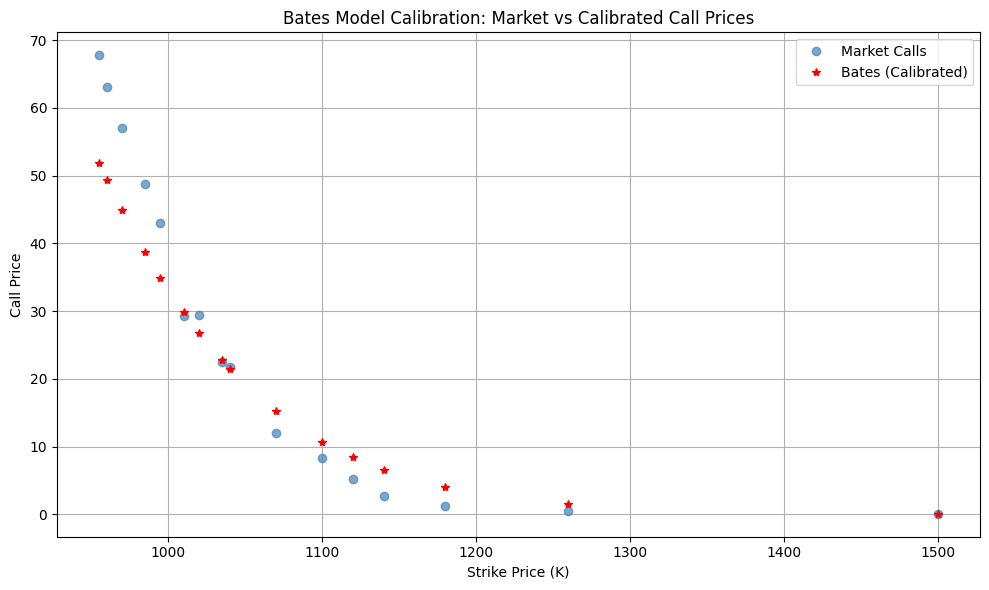

In [16]:
calibrator.plot_calibrated_vs_market(clean_otm_options_df)

In [ ]:
calibrator.plot_calls_and_puts_vs_model(clean_otm_options_df)

[Saved plot] ../assets/calibration_residuals_20250508_150430.png


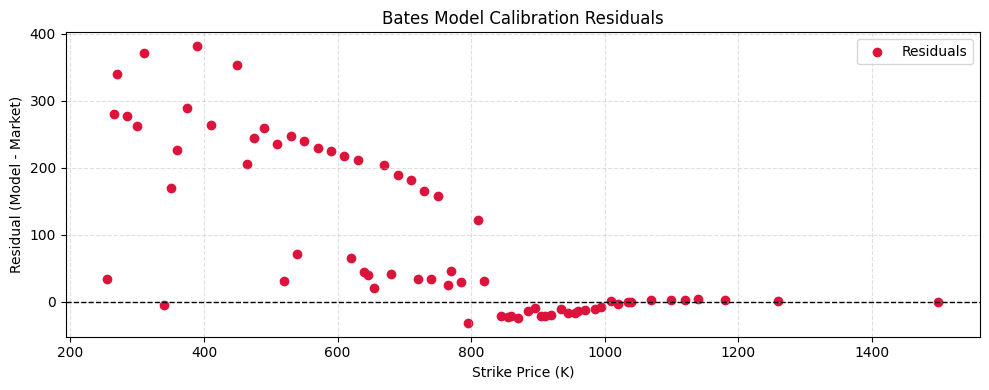

In [ ]:
calibrator.plot_residuals(clean_otm_options_df)